# How to create map-reduce branches for parallel 

This guide assumes familiarity with the following:

*   LangGraph Glossary
*   Send API
*   Chat Models
*   Structured Output

Map-reduce operations are essential for efficient task decomposition and parallel processing. This approach involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.

Consider this example: given a general topic from the user, generate a list of related subjects, generate a joke for each subject, and select the best joke from the resulting list. In this design pattern, a first node may generate a list of objects (e.g., related subjects) and we want to apply some other node (e.g., generate a joke) to all those objects (e.g., subjects). However, two main challenges arise.

(1) the number of objects (e.g., subjects) may be unknown ahead of time (meaning the number of edges may not be known) when we lay out the graph and (2) the input State to the downstream Node should be different (one for each generated object).

LangGraph addresses these challenges through its Send API. By utilizing conditional edges, Send can distribute different states (e.g., subjects) to multiple instances of a node (e.g., joke generation). Importantly, the sent state can differ from the core graph's state, allowing for flexible and dynamic workflow management.


error at last step

## Setup

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Define the graph

In [10]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)


model = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this as an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
graph = graph.compile()

### Visualize

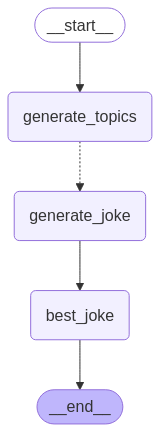

In [11]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Use the graph

In [12]:
# Call the graph: here we call it to generate a list of jokes
for s in graph.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['elephant', 'tiger', 'dolphin', 'penguin', 'giraffe']}}
{'generate_joke': {'jokes': ['Why don’t penguins like talking to strangers at parties? \n\nBecause they find it hard to break the ice!']}}
{'generate_joke': {'jokes': ["Why do elephants never use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ['Why did the dolphin bring a towel to the party? \n\nBecause it wanted to have a whale of a time!']}}
{'generate_joke': {'jokes': ['Why did the tiger eat the tightrope walker?  \nBecause he wanted a well-balanced meal!']}}
{'generate_joke': {'jokes': ["Why don't giraffes like fast food? \n\nBecause they can't catch it!"]}}


c:\Users\gs\Documents\AI24\LangChain_202409\lg_my_examples\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:410: UserWarning: Invalid schema for OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. Specify `method="function_calling"` instead or update your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas
  warnings.warn(message)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'BestJoke': In context=('properties', 'id'), 'minimum' is not permitted.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}